<a href="https://colab.research.google.com/github/rjunw/supcon-adversarial/blob/main/breast_ultrasound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Project: Breast Cancer Ultrasound Dataset

## Part 0: Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm.notebook import tqdm
import os
import copy
import pandas as pd
import PIL 
import random
from collections import defaultdict

# For reproducibility
torch.manual_seed(1234)
  
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Using the GPU!


In [2]:
# !pip install wilds

# from wilds import get_dataset
# from wilds.common.data_loaders import get_train_loader
import torchvision.transforms as transforms

In [3]:
# get kaggle dataset
!pip install kaggle 

# set up api 
import os
os.environ['KAGGLE_USERNAME'] = 'cinmeow520'
os.environ['KAGGLE_KEY'] = '7717d85a5986bf4de583012bb1b235c6'


!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset
!unzip breast-ultrasound-images-dataset.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 193M/195M [00:10<00:00, 23.3MB/s]
100% 195M/195M [00:10<00:00, 20.3MB/s]
Archive:  breast-ultrasound-images-dataset.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with

#### Dataset 1: Breast Ultrasound Dataset

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


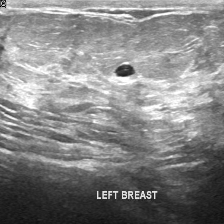

<ipython-input-4-4a586a8834ed>:41: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  full_data = np.array(norm + ben + mal)
<ipython-input-4-4a586a8834ed>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  full_data = np.array(norm + ben + mal)


In [4]:
# image loading 
from torchvision.io import read_image

img_path = "/content/Dataset_BUSI_with_GT/benign/benign (1).png"
img = read_image(img_path)
t = transforms.Resize((224, 224))
img = t(img)
img = transforms.ToPILImage()(img)
img.show()

# load all images, excluding mask data 
IMG_PATH = "/content/Dataset_BUSI_with_GT/"
SUBDIR = ["normal", "benign", "malignant"] # normal = 0, benign = 1, malignant = 2


def load_images(tclass):
  path = os.path.join(IMG_PATH, tclass)
  fnames = [os.path.join(path, fname) for fname in os.listdir(path)]
  data, labels = [], []
  for fname in fnames:
    if not ("mask" in fname):
      #print(fname)
      img = read_image(fname)
      img = t(img)
      if "normal" or "benign" in fname:
        data.append(img)
        #labels.append(0)
      if "malignant" in fname:
        data.append(img)
        #labels.append(1)
  return data#, labels

norm = load_images('normal')
ben = load_images('benign')
mal = load_images('malignant')

nlab = [0] * len(norm)
blab = [0] * len(ben)
mlab = [1] * len(mal)

full_data = np.array(norm + ben + mal)
full_lab = np.array(nlab + blab + mlab)

In [5]:
from torch.utils.data import Dataset, DataLoader

# create dataset class 

class BreastUltrasound(Dataset):
  def __init__(self, images, labels, transform = None):
    self.images = images
    self.labels = torch.tensor(labels)
    self.labels = self.labels.to(device)
    self.transform = transform
  
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, index):
    # x = self.images[index]
    # x = self.transform(x.float())
    # y = self.labels[index]
    # x.to(float)
    return self.images[index], self.labels[index]

In [6]:
import random 
# train, val, test split 

# size of each 
sz = len(full_data)
trdex, vdex, tdex = round(sz*0.8), round(sz*0.1), round(sz*0.1)

# get the set indicies
indicies = list(range(len(full_data)))
random.shuffle(indicies)
trdex, vdex, tdex = indicies[:trdex], indicies[trdex:trdex+vdex], indicies[trdex+vdex:]

# get the x y of each set
x_train, x_val, x_test = full_data[trdex], full_data[vdex], full_data[tdex]
y_train, y_val, y_test = full_lab[trdex], full_lab[vdex], full_lab[tdex]

In [7]:
import torchvision.transforms as transforms

In [8]:
# data augmentation 
# transform = transforms.Compose([
#     #transforms.RandomRotation(35), 
#     transforms.RandomPerspective(0.2), 
#     transforms.RandomVerticalFlip(0.3), 
#     transforms.RandomInvert(0.2), 
#     transforms.RandomAutocontrast(0.4)
#     #, 
#     #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# ])

train = BreastUltrasound(x_train, y_train)
val = BreastUltrasound(x_val, y_val)
test = BreastUltrasound(x_test, y_test)

# data loaders 
train_loader = DataLoader(train, batch_size = 10)
val_loader = DataLoader(val, batch_size = 10)


## Part 1: Baseline Network - Regular Cross Entropy

In [9]:
# set up 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(device)

In [10]:
import torchvision.models as netmodels

In [11]:
# we will use resnet50 as baseline model

class ResNet50(nn.Module):
  def __init__(self, num_classes):
    # super class 
    super(ResNet50, self).__init__()
    self.resnet = netmodels.resnet50(pretrained=True) # set with pretrained for now 

    # remove last layer: (fc): Linear(in_features=2048, out_features=1000, bias=True)
    self.features = nn.Sequential(*list(self.resnet.children())[:-1])

    # add layers 
    #model.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.fc = nn.Sequential(
        nn.Linear(in_features=self.resnet.fc.in_features, out_features=1000), 
        nn.BatchNorm1d(1000), 
        nn.Dropout(0.2), 
        nn.Linear(1000, 2)
    )
  
  def forward(self, x):
    x = x.to(device)
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    x = x.to(device)
    return x

baseline_model = ResNet50(2)
baseline_model = baseline_model.to(device)

# define parameters 
params = baseline_model.parameters()

# learning rate
learning_rate = 0.001

# define optimizer 
optimizer = optim.Adam(params, lr=learning_rate) 

# loss function 
loss_fc = nn.CrossEntropyLoss()

print(baseline_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 291MB/s]


ResNet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [12]:
# section modeled after pset 5 
# edit such that i can save and return the training and validation losses

def standard_training(model, epochs, loss_fc, optimizer, train_loader, val_loader): 
  model.to(device)

  # training arc

  EPOCHS = epochs
  best_acc = 0
  training_loss = []
  validation_loss = []
  
  training_accuracy = []
  val_accuracy = []

  for epoch in range(EPOCHS):
    for arc in ['train', 'val']:
      
      if arc == 'train': 
        model.train()
        dloader = train_loader
      else: 
        model.eval()
        dloader = val_loader

      train_loss = 0.0
      train_acc = 0

      val_loss = 0.0
      val_acc = 0

      for images, labels in tqdm(dloader): 
        images, labels = images.to(device), labels.to(device)
        # optimizer 
        optimizer.zero_grad()

        # forward pass 
        #with torch.autograd.detect_anomaly():
        with torch.set_grad_enabled(arc == 'train'): 
          images = images.float()
          outputs = model(images)
          loss = loss_fc(outputs, labels)

          _, preds = torch.max(outputs, 1)

          # backward
          if arc == "train":
            loss.backward()
            optimizer.step()

        # add to loss
        if arc == 'train':
          train_loss += loss.item()
          # print(preds.shape)
          # print(labels.shape)
          train_acc += torch.sum(preds == labels)
        else: 
          val_loss += loss.item()
          val_acc += torch.sum(preds == labels)

      if arc == 'train':
        epoch_tr_loss = train_loss / (len(dloader)*10)
        epoch_tr_acc = train_acc.double() / (len(dloader)*10)
        training_loss.append(epoch_tr_loss)
        training_accuracy.append(epoch_tr_acc)
      else: 
        epoch_val_loss = val_loss / (len(dloader)*10)
        epoch_val_acc = val_acc.double() / (len(dloader)*10)
        validation_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_acc)
      

    print("Epoch " + str(epoch))
    print("Training Loss: {:.4f}".format(epoch_tr_loss))
    print("Training Acc: {:.4f}".format(epoch_tr_acc))
    print("Validation Loss: {:.4f}".format(epoch_val_loss))
    print("Validation Acc: {:.4f}".format(epoch_val_acc))

    if epoch_val_acc > best_acc:
      best_acc = epoch_val_acc
  print() 
  print("Best Validation Acc: {:.4f}".format(best_acc))

  history = {"loss": [training_loss, validation_loss], "accuracy": [training_accuracy, val_accuracy]}
  return history

In [13]:
hist = standard_training(baseline_model, 20, loss_fc, optimizer, train_loader, val_loader)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
Training Loss: 0.0946
Training Acc: 0.6112
Validation Loss: 0.0892
Validation Acc: 0.7400


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
Training Loss: 0.0525
Training Acc: 0.7625
Validation Loss: 0.0945
Validation Acc: 0.5900


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2
Training Loss: 0.0543
Training Acc: 0.7525
Validation Loss: 0.0696
Validation Acc: 0.5700


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3
Training Loss: 0.0570
Training Acc: 0.7075
Validation Loss: 0.4073
Validation Acc: 0.3500


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4
Training Loss: 0.0573
Training Acc: 0.7000
Validation Loss: 0.0547
Validation Acc: 0.7100


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5
Training Loss: 0.0485
Training Acc: 0.7875
Validation Loss: 0.0398
Validation Acc: 0.8300


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6
Training Loss: 0.0463
Training Acc: 0.7913
Validation Loss: 0.0416
Validation Acc: 0.8400


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7
Training Loss: 0.0463
Training Acc: 0.8075
Validation Loss: 0.0350
Validation Acc: 0.8900


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8
Training Loss: 0.0467
Training Acc: 0.8075
Validation Loss: 0.0456
Validation Acc: 0.8100


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9
Training Loss: 0.0359
Training Acc: 0.8488
Validation Loss: 0.0344
Validation Acc: 0.8400


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10
Training Loss: 0.0278
Training Acc: 0.8900
Validation Loss: 0.0723
Validation Acc: 0.7800


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11
Training Loss: 0.0216
Training Acc: 0.9138
Validation Loss: 0.0198
Validation Acc: 0.9000


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12
Training Loss: 0.0373
Training Acc: 0.8550
Validation Loss: 0.0426
Validation Acc: 0.7900


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13
Training Loss: 0.0440
Training Acc: 0.8237
Validation Loss: 4.6398
Validation Acc: 0.5200


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14
Training Loss: 0.0522
Training Acc: 0.8037
Validation Loss: 0.0714
Validation Acc: 0.7300


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15
Training Loss: 0.0500
Training Acc: 0.8363
Validation Loss: 0.1271
Validation Acc: 0.6900


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16
Training Loss: 0.0710
Training Acc: 0.6900
Validation Loss: 0.1799
Validation Acc: 0.6100


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17
Training Loss: 0.0467
Training Acc: 0.8087
Validation Loss: 0.0294
Validation Acc: 0.8700


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18
Training Loss: 0.0290
Training Acc: 0.8625
Validation Loss: 0.0581
Validation Acc: 0.7800


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19
Training Loss: 0.0284
Training Acc: 0.8738
Validation Loss: 0.0331
Validation Acc: 0.8800

Best Validation Acc: 0.9000


In [14]:
torch.save(baseline_model.state_dict(), 'baseline.pth')

In [15]:
test_loader = DataLoader(test, batch_size = 10)

In [16]:
baseline_model.eval()

scores = []
predictions = []
actual = []

with torch.set_grad_enabled(False): 
  for x, y in test_loader: 
    outputs = baseline_model(x.float())
    loss = loss_fc(outputs, y)

    score , preds = torch.max(outputs, 1)
    scores.append(score.tolist())
    predictions.append(preds.tolist())
    actual.append(y.tolist())

In [17]:
print(predictions)
print(actual)

[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0], [0, 0, 1, 0, 0, 1, 1, 1, 0, 0], [1, 0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 1, 1, 1, 0, 0, 1, 0, 0, 1], [1, 1, 0, 0, 1, 0, 0, 1, 0, 1], [0, 0, 1, 0, 1, 1, 0, 1, 0, 1], [1, 0, 0, 0, 1, 0, 1, 0, 0, 1], [1, 0, 0, 1, 0, 1, 1, 0, 1, 0], [1, 0, 0, 0, 1, 1, 0, 1, 1]]
[[1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 1, 1, 1, 1, 0], [1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 1, 1, 1, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 1, 0, 0, 1, 0, 1], [0, 1, 1, 0, 0, 1, 0, 0, 0, 1], [1, 0, 0, 0, 1, 1, 1, 0, 0, 1], [1, 0, 0, 1, 0, 1, 1, 0, 1, 0], [1, 0, 0, 0, 1, 1, 0, 1, 1]]


In [18]:
from sklearn.metrics import roc_auc_score

correct = 0
total = 0
for i in range(len(predictions)): 
  correct += sum(np.array(predictions[i]) == np.array(actual[i]))
  total += len(predictions[i])

flat_scores = []
flat_actual = []
for i in range(len(score)): 
  flat_scores.extend(scores[i])
  flat_actual.extend(actual[i])

print("Accuracy: ", correct/total)
print("AUC: ", roc_auc_score(flat_actual, flat_scores))

Accuracy:  0.898989898989899
AUC:  0.45843703334992536


## Part 2: Adversarial Cross Entropy Loss

In [19]:

def fgsm(model, x, y, criterion, eps):
    """
    https://adversarial-ml-tutorial.org/adversarial_examples/
    """
    delta = torch.zeros_like(x, requires_grad=True) # noise with gradients
    loss = criterion(model(x + delta), y) # loss wrt perturbed input
    loss.backward() # backprop on delta
    return eps * delta.grad.detach().sign() # FGSM pertubation



def pgd_linf(model, x, y, criterion, eps, step_size, adv_steps, randomize = True):
    """ 
    PGD l-inf norm
    https://adversarial-ml-tutorial.org/adversarial_examples/
    """
    if randomize: 
        x = x.to(torch.float32)
        x = x.to(device)
        delta = torch.rand_like(x, requires_grad=True) # uniform random -> can start pertubations at different locations
        delta.data = delta.data * 2 * eps - eps
    else:
        delta = torch.zeros_like(x, requires_grad=True) # start w/ no noise

    delta = delta.to(device)
    for t in range(adv_steps):
      # print("x", x.is_cuda)
      # print("delta", delta.is_cuda)
      # print("model", list(model.parameters())[0].is_cuda)
      z = model(x + delta)
      z = z.to(device)
      y = y.to(device)

      # print("z", z.is_cuda)
      # print("y", y.is_cuda)
      # #print(z.shape)
      loss = criterion(z, y) # perturbed loss
      loss.backward() # gradiets wrt delta 
      delta.data = (delta + step_size*delta.grad.detach().sign()).clamp(-eps,eps) # linf clamp
      delta.grad.zero_() # reset grads
    return delta.detach() # optimal perturbation projected onto linf ball



In [20]:

# https://github.com/HobbitLong/SupContrast/blob/master/losses.py
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn


class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    
    -- Ryan
    Modifications made as per https://github.com/HobbitLong/SupContrast/issues/104
    """
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        # normalize
        features = torch.nn.functional.normalize(features, p=2, dim=2)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one': # compare to one anchor
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all': # compare all
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-6)

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask*log_prob).sum(1)/(mask.sum(1)+1e-6)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [21]:

# AE module
class Encoder(nn.Module):
    def __init__(self, x_dim, z_dim, fc_dims):
        super(Encoder, self).__init__()
        self.fc_dims = fc_dims

        # encoder modules 
        if not self.fc_dims: # no hidden layers
            self.encoder = nn.Linear(x_dim, z_dim)
        else: # arbitrary layers
            encoder = [nn.Linear(x_dim, self.fc_dims[0])]
            for i in range(1, len(self.fc_dims)):
                encoder.append(nn.Linear(self.fc_dims[i-1], self.fc_dims[i]))
            encoder.append(nn.Linear(self.fc_dims[-1], z_dim))
            self.encoder = nn.ModuleList(encoder)

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, x_dim, z_dim, fc_dims):
        super(Decoder, self).__init__()

        # reverse encoder fc's
        self.fc_dims = [fc_dims[i] for i in range(len(fc_dims) - 1, -1)]

        # decoder modules 
        if not self.fc_dims: # no hidden layers
            self.decoder = nn.Linear(z_dim, x_dim)
        else: # arbitrary layers
            decoder = [nn.Linear(z_dim, self.fc_dims[0])]
            for i in range(1, len(self.fc_dims)):
                decoder.append(nn.Linear(self.fc_dims[i-1], self.fc_dims[i]))
            decoder.append(nn.Linear(self.fc_dims[-1], x_dim))
            self.decoder = nn.ModuleList(decoder)

    def forward(self, z):
        return self.decoder(z)

class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super(self, Autoencoder).__init__()
        self.encoder = Encoder(**kwargs)
        self.decoder = Decoder(**kwargs)

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        xhat = self.decode(z)
        return z, xhat

In [22]:
def epoch_adversarial(model, criterion, loader, epoch, eps=0.2, step_size=1e-2, adv_steps=40, optimizer = None, device = 'cpu'):
    """
    eps -- l_inf bound
    step_size -- delta stepsize for inner maximization
    adv_steps -- number of steps of adversarial pertubation
    """
    if optimizer:
        model.train()
        mode = 'Train'
    else:
        model.eval()
        mode = 'Val'

    train_loss = []
    corr, count = 0, 0
    batches = tqdm(enumerate(loader), total=len(loader))
    batches.set_description("Epoch NA: Adversarial Loss (NA)")

    for batch_idx, (x, y) in batches:
        x, y = x.to(device), y.to(device)
        # inner maximization
        delta = pgd_linf(model, x, y, criterion, eps, step_size, adv_steps)
        delta = delta.to(device)
        # outer minimization
        z = model(x + delta)
        z = z.to(device)
        loss = criterion(z, y)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss.append(loss.item())
        # batches.set_description(
        #     "Epoch {:d}: {:s} Adversarial Loss ({:.2e})".format(
        #         epoch,mode, loss.item()
        #     )
        # )

        corr, count = corr + (z.max(axis = 1).indices == y).float().sum(), count + y.shape[0]
        accuracy = 100 * corr / count #if show_acc else torch.tensor([-1.0])

        batches.set_description(
            "Adversarial Epoch {:d}: {:s} Loss ({:.2e}) ACC ({:.2f})".format(
                epoch, mode, loss.item(), accuracy.item()
            )
        )
        
    return np.mean(train_loss), accuracy.item()

In [23]:
# setting up 
adv_model = ResNet50(2)
adv_model = adv_model.to(device)

# loss function 
loss_fc = nn.CrossEntropyLoss()
loss_fc = loss_fc.to(device)

# learning rate
learning_rate = 0.001

# define optimizer 
params = adv_model.parameters()
optimizer = optim.Adam(params, lr=learning_rate) 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
###### Train Model ######
train_losses = {'standard':[], 'adversarial':[]}
val_losses = {'standard':[], 'adversarial':[]}
best_val = float("inf")
best_epoch = 0

train_acc, val_acc = [], []

EPOCHS = 20
VAL_TYPE = 'adversarial'

for epoch in tqdm(range(EPOCHS)):

    # train 
    #train_loss = standard_training(model, epochs, loss_fc, optimizer)
    train_loss_adv, train_acc_adv = epoch_adversarial(adv_model, loss_fc, train_loader, epoch, eps=0.2, step_size=1e-2, adv_steps=10, optimizer = optimizer, device = device)
    #train_losses['standard'].append(train_loss)
    train_losses['adversarial'].append(train_loss_adv)
    train_acc.append(train_acc_adv)

    # eval 
    #val_loss = standard_training(net, criterion, val_loader, epoch, optimizer = None, device = device)
    val_loss_adv, val_acc_adv = epoch_adversarial(adv_model, loss_fc, val_loader, epoch, eps=0.2, step_size=1e-2, adv_steps=10, optimizer = None, device = device)
    #val_losses['standard'].append(val_loss)
    val_losses['adversarial'].append(val_loss_adv)
    val_acc.append(val_acc_adv)

    # retain best val
    if best_val > val_losses[VAL_TYPE][-1]:
        best_val = val_losses[VAL_TYPE][-1]
        best_epoch = epoch
        # save model parameter/state dictionary

# load best weights
print(f"Loss Metric: Best epoch at {best_epoch} with {VAL_TYPE} loss: {best_val}")
#print(f"Accuracy Metric: Best epoch at {best_epoch_acc} with {VAL_TYPE} accuracy: {best_acc}")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss Metric: Best epoch at 15 with adversarial loss: 0.2344096913933754


In [25]:
torch.save(adv_model.state_dict(), 'adv_weights.pth')

In [26]:
max(val_acc), min(val_losses['adversarial'])

(91.919189453125, 0.2344096913933754)

In [27]:
# testing  
adv_model.eval()

scores = []
predictions = []
actual = []

with torch.set_grad_enabled(False): 
  for x, y in test_loader: 
    outputs = adv_model(x.float())
    loss = loss_fc(outputs, y)

    score , preds = torch.max(outputs, 1)
    scores.append(score.tolist())
    predictions.append(preds.tolist())
    actual.append(y.tolist())


correct = 0
total = 0
for i in range(len(predictions)): 
  correct += sum(np.array(predictions[i]) == np.array(actual[i]))
  total += len(predictions[i])

flat_scores = []
flat_actual = []
for i in range(len(score)): 
  flat_scores.extend(scores[i])
  flat_actual.extend(actual[i])

print("Accuracy: ", correct/total)
print("AUC: ", roc_auc_score(flat_actual, flat_scores))


Accuracy:  0.8383838383838383
AUC:  0.30164260826281736


In [28]:
adv_hist = {"loss": [train_losses['adversarial'], val_losses['adversarial']], "accuracy": [train_acc, val_acc]}

In [29]:
###### Train FINE TUNED Model ######
adv_ft = ResNet50(2).to(device)
adv_ft.features = copy.deepcopy(adv_model.features)

train_losses = {'standard':[], 'adversarial':[]}
val_losses = {'standard':[], 'adversarial':[]}
best_val = float("inf")
best_epoch = 0

train_acc, val_acc = [], []

EPOCHS = 20
VAL_TYPE = 'adversarial'

for epoch in tqdm(range(EPOCHS)):

    # train 
    #train_loss = standard_training(model, epochs, loss_fc, optimizer)
    train_loss_adv, train_acc_adv = epoch_adversarial(adv_ft, loss_fc, train_loader, epoch, eps=0.2, step_size=1e-2, adv_steps=10, optimizer = optimizer, device = device)
    #train_losses['standard'].append(train_loss)
    train_losses['adversarial'].append(train_loss_adv)
    train_acc.append(train_acc_adv)

    # eval 
    #val_loss = standard_training(net, criterion, val_loader, epoch, optimizer = None, device = device)
    val_loss_adv, val_acc_adv = epoch_adversarial(adv_ft, loss_fc, val_loader, epoch, eps=0.2, step_size=1e-2, adv_steps=10, optimizer = None, device = device)
    #val_losses['standard'].append(val_loss)
    val_losses['adversarial'].append(val_loss_adv)
    val_acc.append(val_acc_adv)

    # retain best val
    if best_val > val_losses[VAL_TYPE][-1]:
        best_val = val_losses[VAL_TYPE][-1]
        best_epoch = epoch
        # save model parameter/state dictionary

# load best weights
print(f"Loss Metric: Best epoch at {best_epoch} with {VAL_TYPE} loss: {best_val}")
#print(f"Accuracy Metric: Best epoch at {best_epoch_acc} with {VAL_TYPE} accuracy: {best_acc}") 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Loss Metric: Best epoch at 5 with adversarial loss: 1.9295599102973937


In [30]:
adv_ft_hist = {"loss": [train_losses['adversarial'], val_losses['adversarial']], "accuracy": [train_acc, val_acc]}

In [33]:
# testing  
adv_ft.eval()

scores = []
predictions = []
actual = []

with torch.set_grad_enabled(False): 
  for x, y in test_loader: 
    outputs = adv_ft(x.float())
    loss = loss_fc(outputs, y)

    score , preds = torch.max(outputs, 1)
    scores.append(score.tolist())
    predictions.append(preds.tolist())
    actual.append(y.tolist())


correct = 0
total = 0
for i in range(len(predictions)): 
  correct += sum(np.array(predictions[i]) == np.array(actual[i]))
  total += len(predictions[i])

flat_scores = []
flat_actual = []
for i in range(len(score)): 
  flat_scores.extend(scores[i])
  flat_actual.extend(actual[i])

print("Accuracy: ", correct/total)
print("AUC: ", roc_auc_score(flat_actual, flat_scores))


Accuracy:  0.37373737373737376
AUC:  0.08262817322050771


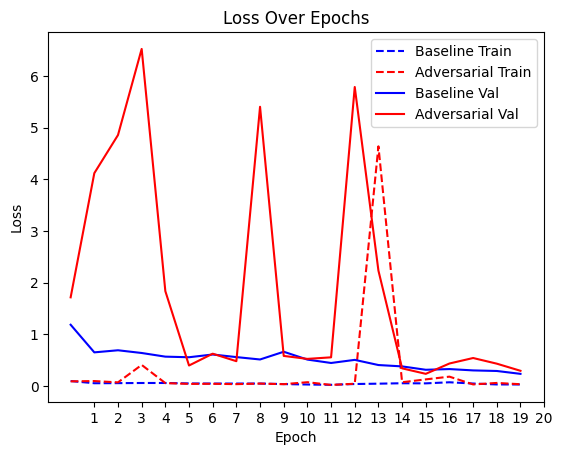

In [34]:
# plot these two first for now 

# losses plot 
b_tr, ad_tr = hist['loss']
b_val, ad_val = adv_hist['loss']

plt.plot(b_tr, color='blue', label='Baseline Train', linestyle='--')
plt.plot(ad_tr, color='red', label="Adversarial Train", linestyle='--')
plt.plot(b_val, color='blue', label='Baseline Val')
plt.plot(ad_val, color='red', label='Adversarial Val')

# legend 
plt.legend()

# labels 
plt.xlabel ("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")

# xticks 
plt.xticks(list(range(1, 21)))

plt.show()

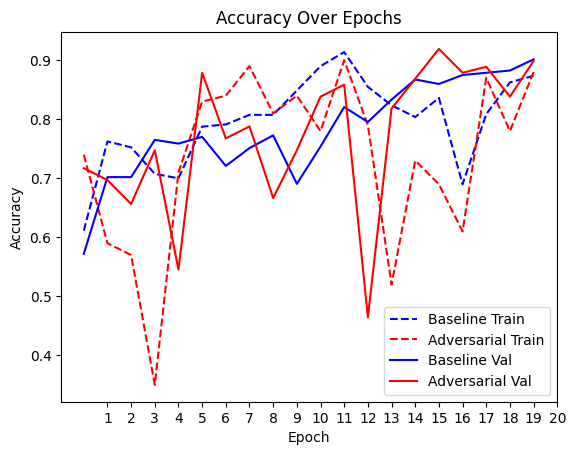

In [35]:
# plot these two first for now 

# losses plot 
b_tr, ad_tr = hist['accuracy']
b_val, ad_val = adv_hist['accuracy']

b_tr = [elem.item() for elem in b_tr]
ad_tr = [elem.item() for elem in ad_tr]

b_val = np.array(b_val)/100
ad_val = np.array(ad_val)/100


plt.plot(b_tr, color='blue', label='Baseline Train', linestyle='--')
plt.plot(ad_tr, color='red', label="Adversarial Train", linestyle='--')
plt.plot(b_val, color='blue', label='Baseline Val')
plt.plot(ad_val, color='red', label='Adversarial Val')

# legend 
plt.legend()

# labels 
plt.xlabel ("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")

# xticks 
plt.xticks(list(range(1, 21)))

plt.show()

## Utils - Supcon

In [41]:
def pgd_linf(model, x, y, criterion, eps, step_size, adv_steps, randomize = True, multi_view = False):
    """ 
    PGD l-inf norm
    https://adversarial-ml-tutorial.org/adversarial_examples/
    x = [x0, x1] where x0 is view 1, x1 is view 2
    """
    if randomize: 
        delta1 = torch.rand_like(x[0], requires_grad=True) # uniform random -> can start pertubations at different locations
        delta1.data = delta1.data * 2 * eps - eps
        delta2 = torch.rand_like(x[1], requires_grad=True) # uniform random -> can start pertubations at different locations
        delta2.data = delta2.data * 2 * eps - eps
    else:
        delta1 = torch.zeros_like(x[0], requires_grad=True) # start w/ no noise
        delta2 = torch.zeros_like(x[1], requires_grad = True)
        
    for t in range(adv_steps):
        if multi_view:
            z1 = model(x[0] + delta1).unsqueeze(1)
            z2 = model(x[1] + delta2).unsqueeze(1)
            z = torch.cat([z1, z2], dim = 1)
        else:
            z = model(x[0] + delta1)
        #print(z.shape)
        loss = criterion(z, y) # perturbed loss
        loss.backward() # gradiets wrt delta 
        delta1.data = (delta1 + step_size*delta1.grad.detach().sign()).clamp(-eps,eps) # linf clamp
        if multi_view:
            delta2.data = (delta2 + step_size*delta2.grad.detach().sign()).clamp(-eps,eps) # linf clamp
            delta2.grad.zero_()
        delta1.grad.zero_() # reset grads
    return [delta1.detach(), delta2.detach()] # optimal perturbation projected onto linf ball

In [42]:
def epoch_standard(model, criterion, loader, epoch, optimizer = None, device = 'cpu', show_acc = False, multi_view = False):
    """
    standard epoch
    """
    if optimizer:
        model.train()
        mode = 'Train'
    else:
        model.eval()
        mode = 'Val'

    train_loss = []
    batches = tqdm(enumerate(loader), total=len(loader))
    batches.set_description("Epoch NA: Loss (NA)")
    correct = 0
    count = 0
    for batch_idx, (x, y) in batches:
      x, y = [x[0].to(device), x[1].to(device)], y.to(device)
      
      if multi_view:
          z = torch.cat([model(x[0]).unsqueeze(1), model(x[1]).unsqueeze(1)], dim = 1)

      else:
          z = model(x[0])
      loss = criterion(z, y)
            
      if optimizer:
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      train_loss.append(loss.item())

      if show_acc:
          correct += (z.max(axis = 1).indices == y).float().sum()
          count += y.shape[0]
      train_loss.append(loss.item())

      acc = 100 * correct / count if show_acc else torch.tensor([-1.0])

      batches.set_description(
            "Epoch {:d}: {:s} Loss ({:.2e}) ACC ({:.2e})".format(
                epoch, mode, loss.item(), acc.item()
            )
        )

    return np.mean(train_loss), acc.detach().cpu().numpy()


def epoch_adversarial(model, criterion, loader, epoch, eps=0.2, step_size=1e-2, adv_steps=40, optimizer = None, device = 'cpu', show_acc = False, multi_view = False):
    """
    eps -- l_inf bound
    step_size -- delta stepsize for inner maximization
    adv_steps -- number of steps of adversarial pertubation
    """
    if optimizer:
        model.train()
        mode = 'Train'
    else:
        model.eval()
        mode = 'Val'

    train_loss = []
    batches = tqdm(enumerate(loader), total=len(loader))
    batches.set_description("Epoch NA: Adversarial Loss (NA)")
    correct = 0
    count = 0
    for batch_idx, (x, y) in batches:
        x, y = [x[0].to(device), x[1].to(device)], y.to(device)
        # inner maximization
        delta = pgd_linf(model, x, y, criterion, eps, step_size, adv_steps, multi_view = multi_view)

        # outer minimization
        if multi_view: # concatenate views
            z = torch.cat([model(x[0] + delta[0]).unsqueeze(1), 
                           model(x[1] + delta[1]).unsqueeze(1)], dim = 1)
        else:
            z = model(x[0] + delta[0])
        loss = criterion(z, y)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss.append(loss.item())

        if show_acc:
            correct += (z.max(axis = 1).indices == y).float().sum()
            count += y.shape[0]
        acc = 100 * correct / count if show_acc else torch.tensor([-1.0])

        batches.set_description(
            "Adversarial Epoch {:d}: {:s} Loss ({:.2e}) ACC ({:.2e})".format(
                epoch, mode, loss.item(), acc.item()
            )
        )
    return np.mean(train_loss), acc.detach().cpu().numpy()

In [43]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

])

eval_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [44]:
class BreastUltrasoundSupCon(Dataset):
  def __init__(self, images, labels, transform = None):
    self.images = images
    self.labels = torch.tensor(labels)
    self.labels = self.labels.to(device)
    self.transform = transform
  
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, index):
    x, y = self.images[index], self.labels[index]
    if self.transform is not None: 
      x = x.to(torch.float)
      x = self.transform(x)
    return x, y

In [45]:
train = BreastUltrasoundSupCon(x_train, y_train, transform = TwoCropTransform(train_transform))
val = BreastUltrasoundSupCon(x_val, y_val, transform = TwoCropTransform(eval_transform))
test = BreastUltrasoundSupCon(x_test, y_test, transform = TwoCropTransform(eval_transform))

# data loaders 
train_loader = DataLoader(train, batch_size = 64)
val_loader = DataLoader(val, batch_size = 64)

## Part 3: Supervised Contrastive Loss 

In [46]:
import torchvision.models as netmodels

In [47]:
# feat extractor
class ResNetFeat(nn.Module):
    """
    resnet feature extractor
    """
    def __init__(self, num_channels, num_classes, out_dim):
        super(ResNetFeat, self).__init__()
        self.resnet = netmodels.resnet50(weights = None)#'IMAGENET1K_V2') # finetuning
        self.resnet.conv1 = nn.Conv2d(num_channels, 64, 7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(2048, num_classes) 
        self.feature_extractor = torch.nn.Sequential(*list(self.resnet.children())[:-1])
        # might need to add a projection head and throw it away afterwards... as per supcon paper
        self.proj = nn.Sequential(
            nn.Linear(2048, 2048), 
            nn.ReLU(inplace=  True),
            nn.Linear(2048, out_dim)
        )

    def forward(self, x):
        z = self.feature_extractor(x).float()
        z = z.squeeze((-2, -1))
        z = self.proj(z)
        z = torch.nn.functional.normalize(z, dim = 1)
        #print(z.shape)
        return z #.unsqueeze(1) # (bsz, num_feat)

    # def forward(self, x):
    #     return self.resnet(x)

class Squeeze(nn.Module): # for classifier
    def forward(self, x):
        return x.squeeze((-2, -1))

In [55]:
def fit_model(net, criterion, train_loader, val_loader, optimizer, n_epochs, adv_kwargs = dict(), device = 'cpu', use_adv = True, show_acc = False, use_val_acc = False, multi_view = False, scheduler = None, VAL_TYPE='standard'):
    ###### Train Model ######
    train_losses = {'standard':[], 'adversarial':[]}
    val_losses = {'standard':[], 'adversarial':[]}
    best_val = float("inf")
    best_epoch = 0
    best_acc = 0
    train_accs = []
    val_accs = []

    for epoch in tqdm(range(n_epochs)):


        # train 
        train_loss, train_acc = epoch_standard(net, criterion, train_loader, epoch, optimizer, device = device, show_acc = show_acc, multi_view = multi_view)
        # standard_training(model, epochs, loss_fc, optimizer, train_loader, val_loader)
        train_losses['standard'].append(train_loss)
        if show_acc:
            train_accs.append(train_acc.item())
        if use_adv:
            train_loss_adv, _ = epoch_adversarial(net, criterion, train_loader, epoch, **adv_kwargs, optimizer = optimizer, device = device, show_acc = show_acc, multi_view = multi_view)
            train_losses['adversarial'].append(train_loss_adv)

        # eval 
        val_loss, val_acc = epoch_standard(net, criterion, val_loader, epoch, optimizer=None, device = device, show_acc = show_acc, multi_view = multi_view)
        val_losses['standard'].append(val_loss)
        if show_acc:
            val_accs.append(val_acc)
        # if use_adv:
        #     val_loss_adv, _ = epoch_adversarial(net, criterion, val_loader, epoch, **adv_kwargs, optimizer = None, device = device, show_acc = show_acc)
        #     val_losses['adversarial'].append(val_loss_adv)
        
        if scheduler is not None:
            scheduler.step()

        # retain best val
        if not use_val_acc:
            print(val_losses)
            if best_val >= val_losses[VAL_TYPE][-1]:
                best_val = val_losses[VAL_TYPE][-1]
                best_epoch = epoch
                print(f"Updating at {best_epoch}")
                # save model parameter/state dictionary
                best_model = copy.deepcopy(net.state_dict())
        else:
            if best_acc <= val_accs[-1]:
                best_acc = val_accs[-1]
                best_epoch = epoch
                print(f"Updating at {best_epoch}")
                # save model parameter/state dictionary
                best_model = copy.deepcopy(net.state_dict())

    # load best weights
    print(f"Best epoch at {best_epoch} with validation loss: {best_val}")
    net.load_state_dict(best_model)
    return train_losses, val_losses, train_accs, val_acc

In [49]:
# setting up 
supcon = ResNetFeat(3, 2, 64).to(device)
supcon_adv = ResNetFeat(3, 2, 64).to(device)

# loss function 
loss_fc = SupConLoss(temperature = 0.1)
loss_fc = loss_fc.to(device)

# learning rate
learning_rate = 3e-4

In [50]:
models = {"supcon": supcon, "supcon_adv": supcon_adv}
optimizers = {'supcon': optim.AdamW(supcon.parameters(), lr=learning_rate),
              'supcon_adv': optim.AdamW(supcon_adv.parameters(), lr=learning_rate)}

In [51]:
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.85)
adv_kwargs = {
    'eps':0.2, 
    'step_size':1e-2, 
    'adv_steps':5
}

In [52]:
samples_per_class = [0 for _ in range(3)]
for _, y in train_loader.dataset:
  samples_per_class[y] += 1

In [53]:
samples_per_class

[459, 333, 0]

In [56]:
train_results = {'supcon': [], 'supcon_adv': []}
val_results = {'supcon': [], 'supcon_adv': []}

for model_name in models: 
  model, optimizer = models[model_name], optimizers[model_name]
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.85)

  # adversarial 
  use_adv = False 
  if "adv" in model_name: 
    use_adv = True

  train_hist, val_hist, train_accs, val_accs = fit_model(model, loss_fc, 
                                                       train_loader, val_loader, optimizer, 20, adv_kwargs, device = device, 
                                                       use_adv = use_adv, show_acc = False, use_val_acc = False, multi_view = True, scheduler = scheduler)
  
  train_results[model_name].append(train_hist)
  train_results[model_name].append(train_accs)

  val_results[model_name].append(val_hist)
  val_results[model_name].append(val_accs)
  


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006], 'adversarial': []}
Updating at 0


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339, 6.4845359325408936], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339, 6.4845359325408936, 6.484358310699463], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339, 6.4845359325408936, 6.484358310699463, 6.484189748764038], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339, 6.4845359325408936, 6.484358310699463, 6.484189748764038, 6.484569072723389], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339, 6.4845359325408936, 6.484358310699463, 6.484189748764038, 6.484569072723389, 6.484553575515747], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339, 6.4845359325408936, 6.484358310699463, 6.484189748764038, 6.484569072723389, 6.484553575515747, 6.484234094619751], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339, 6.4845359325408936, 6.484358310699463, 6.484189748764038, 6.484569072723389, 6.484553575515747, 6.484234094619751, 6.484513998031616], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339, 6.4845359325408936, 6.484358310699463, 6.484189748764038, 6.484569072723389, 6.484553575515747, 6.484234094619751, 6.484513998031616, 6.484362602233887], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339, 6.4845359325408936, 6.484358310699463, 6.484189748764038, 6.484569072723389, 6.484553575515747, 6.484234094619751, 6.484513998031616, 6.484362602233887, 6.48453164100647], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339, 6.4845359325408936, 6.484358310699463, 6.484189748764038, 6.484569072723389, 6.484553575515747, 6.484234094619751, 6.484513998031616, 6.484362602233887, 6.48453164100647, 6.484595775604248], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339, 6.4845359325408936, 6.484358310699463, 6.484189748764038, 6.484569072723389, 6.484553575515747, 6.484234094619751, 6.484513998031616, 6.484362602233887, 6.48453164100647, 6.484595775604248, 6.484593629837036], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339, 6.4845359325408936, 6.484358310699463, 6.484189748764038, 6.484569072723389, 6.484553575515747, 6.484234094619751, 6.484513998031616, 6.484362602233887, 6.48453164100647, 6.484595775604248, 6.484593629837036, 6.484576463699341], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339, 6.4845359325408936, 6.484358310699463, 6.484189748764038, 6.484569072723389, 6.484553575515747, 6.484234094619751, 6.484513998031616, 6.484362602233887, 6.48453164100647, 6.484595775604248, 6.484593629837036, 6.484576463699341, 6.484541893005371], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.484139919281006, 6.4845640659332275, 6.484558820724487, 6.484554290771484, 6.484544277191162, 6.484492063522339, 6.4845359325408936, 6.484358310699463, 6.484189748764038, 6.484569072723389, 6.484553575515747, 6.484234094619751, 6.484513998031616, 6.484362602233887, 6.48453164100647, 6.484595775604248, 6.484593629837036, 6.484576463699341, 6.484541893005371, 6.484445810317993], 'adversarial': []}
Best epoch at 0 with validation loss: 6.484139919281006


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105], 'adversarial': []}
Updating at 0


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955, 6.484492540359497], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955, 6.484492540359497, 6.484494924545288], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955, 6.484492540359497, 6.484494924545288, 6.484495162963867], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955, 6.484492540359497, 6.484494924545288, 6.484495162963867, 6.484495401382446], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955, 6.484492540359497, 6.484494924545288, 6.484495162963867, 6.484495401382446, 6.484495639801025], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955, 6.484492540359497, 6.484494924545288, 6.484495162963867, 6.484495401382446, 6.484495639801025, 6.484494686126709], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955, 6.484492540359497, 6.484494924545288, 6.484495162963867, 6.484495401382446, 6.484495639801025, 6.484494686126709, 6.484489917755127], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955, 6.484492540359497, 6.484494924545288, 6.484495162963867, 6.484495401382446, 6.484495639801025, 6.484494686126709, 6.484489917755127, 6.484494686126709], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955, 6.484492540359497, 6.484494924545288, 6.484495162963867, 6.484495401382446, 6.484495639801025, 6.484494686126709, 6.484489917755127, 6.484494686126709, 6.4844970703125], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955, 6.484492540359497, 6.484494924545288, 6.484495162963867, 6.484495401382446, 6.484495639801025, 6.484494686126709, 6.484489917755127, 6.484494686126709, 6.4844970703125, 6.484492063522339], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955, 6.484492540359497, 6.484494924545288, 6.484495162963867, 6.484495401382446, 6.484495639801025, 6.484494686126709, 6.484489917755127, 6.484494686126709, 6.4844970703125, 6.484492063522339, 6.484485387802124], 'adversarial': []}
Updating at 16


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955, 6.484492540359497, 6.484494924545288, 6.484495162963867, 6.484495401382446, 6.484495639801025, 6.484494686126709, 6.484489917755127, 6.484494686126709, 6.4844970703125, 6.484492063522339, 6.484485387802124, 6.484498500823975], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955, 6.484492540359497, 6.484494924545288, 6.484495162963867, 6.484495401382446, 6.484495639801025, 6.484494686126709, 6.484489917755127, 6.484494686126709, 6.4844970703125, 6.484492063522339, 6.484485387802124, 6.484498500823975, 6.484494686126709], 'adversarial': []}


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'standard': [6.4844889640808105, 6.484492063522339, 6.484494209289551, 6.4844911098480225, 6.484493732452393, 6.4844982624053955, 6.484492540359497, 6.484494924545288, 6.484495162963867, 6.484495401382446, 6.484495639801025, 6.484494686126709, 6.484489917755127, 6.484494686126709, 6.4844970703125, 6.484492063522339, 6.484485387802124, 6.484498500823975, 6.484494686126709, 6.4844958782196045], 'adversarial': []}
Best epoch at 16 with validation loss: 6.484485387802124


In [57]:
# getting accuracies
supcon_ce = ResNet50(2).to(device)
supcon_adv_ce = ResNet50(2).to(device)

# replace features
supcon_ce.features = copy.deepcopy(supcon.feature_extractor)
supcon_adv_ce.features = copy.deepcopy(supcon.feature_extractor)

# criterion 
loss_fc = nn.CrossEntropyLoss().to(device)

# optimizer 
learning_rate = 0.001 

# model dict
models = {'supcon_ce': supcon_ce, 'supcon_adv_ce': supcon_adv_ce}

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [58]:
train_out = {'supcon_ce': [], 'supcon_adv_ce': []}
val_out = {'supcon_ce': [], 'supcon_adv_ce': []}

for m in models: 
  model = models[m]
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
  train_hist, val_hist, train_accs, val_accs = fit_model(model, loss_fc, 
                                     train_loader, val_loader, 
                                     optimizer, 20, adv_kwargs, 
                                     device = device, use_adv = False,
                                     show_acc = True, 
                                     use_val_acc = True,
                                     scheduler = scheduler)
  train_out[m].append(train_hist)
  train_out[m].append(train_accs)
  val_out[m].append(val_hist)
  val_out[m].append(val_accs)
  


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Updating at 0


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Updating at 1


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Updating at 4


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Updating at 5


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Best epoch at 5 with validation loss: inf


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Updating at 0


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Updating at 1


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Updating at 2


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Updating at 3


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Updating at 4


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Updating at 14


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Updating at 15


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Updating at 16


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Best epoch at 16 with validation loss: inf


In [59]:
# testing  
supcon_ce.eval()

scores = []
predictions = []
actual = []

with torch.set_grad_enabled(False): 
  for x, y in test_loader: 
    outputs = supcon_ce(x.float())
    loss = loss_fc(outputs, y)

    score , preds = torch.max(outputs, 1)
    scores.append(score.tolist())
    predictions.append(preds.tolist())
    actual.append(y.tolist())


correct = 0
total = 0
for i in range(len(predictions)): 
  correct += sum(np.array(predictions[i]) == np.array(actual[i]))
  total += len(predictions[i])

flat_scores = []
flat_actual = []
for i in range(len(score)): 
  flat_scores.extend(scores[i])
  flat_actual.extend(actual[i])

print("Accuracy: ", correct/total)
print("AUC: ", roc_auc_score(flat_actual, flat_scores))

Accuracy:  0.43434343434343436
AUC:  0.2842210054753609


In [61]:
# testing  
supcon_adv_ce.eval()

scores = []
predictions = []
actual = []

with torch.set_grad_enabled(False): 
  for x, y in test_loader: 
    outputs = supcon_adv_ce(x.float())
    loss = loss_fc(outputs, y)

    score , preds = torch.max(outputs, 1)
    scores.append(score.tolist())
    predictions.append(preds.tolist())
    actual.append(y.tolist())


correct = 0
total = 0
for i in range(len(predictions)): 
  correct += sum(np.array(predictions[i]) == np.array(actual[i]))
  total += len(predictions[i])

flat_scores = []
flat_actual = []
for i in range(len(score)): 
  flat_scores.extend(scores[i])
  flat_actual.extend(actual[i])

print("Accuracy: ", correct/total)
print("AUC: ", roc_auc_score(flat_actual, flat_scores))

Accuracy:  0.46464646464646464
AUC:  0.30562468889995026


In [70]:
supcon_ce_tr_loss = train_out['supcon_ce'][0]['standard']
supcon_ce_val_acc = np.array(train_out['supcon_ce'][1])/100

In [72]:
supconadv_ce_tr_loss = train_out['supcon_adv_ce'][0]['standard']
supconadv_ce_val_acc = np.array(train_out['supcon_adv_ce'][1])/100

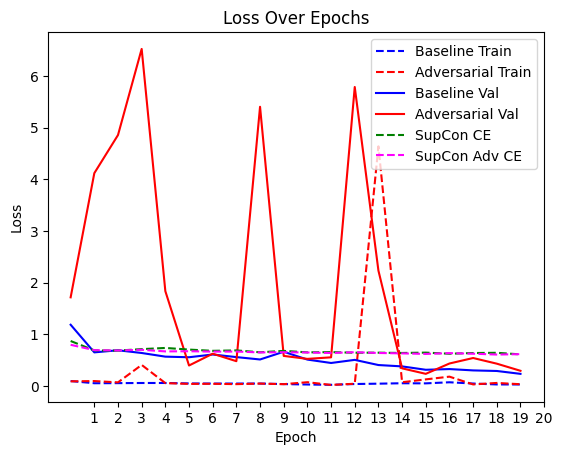

In [68]:
# plot these two first for now 

# losses plot 
b_tr, ad_tr = hist['loss']
b_val, ad_val = adv_hist['loss']

supcon_tr, supcon_adv_tr = train_out['supcon_ce'], train_out['supcon_adv_ce']
supcon_val, supcon_adv_val = val_out['supcon_ce'], val_out['supcon_adv_ce']

plt.plot(b_tr, color='blue', label='Baseline Train', linestyle='--')
plt.plot(ad_tr, color='red', label="Adversarial Train", linestyle='--')
plt.plot(b_val, color='blue', label='Baseline Val')
plt.plot(ad_val, color='red', label='Adversarial Val')

plt.plot(supcon_ce_tr_loss, color='green', label='SupCon CE', linestyle='--')
plt.plot(supconadv_ce_tr_loss, color='magenta', label="SupCon Adv CE", linestyle='--')
# plt.plot(b_val, color='green', label='SupCon CE')
# plt.plot(ad_val, color='magenta', label='SupCon ADv CE')

# legend 
plt.legend()

# labels 
plt.xlabel ("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")

# xticks 
plt.xticks(list(range(1, 21)))

plt.show()


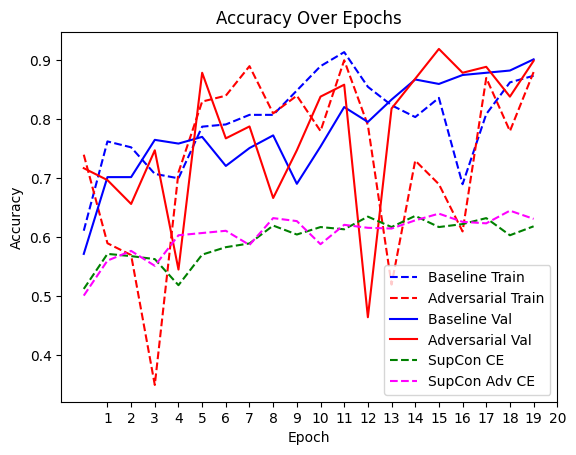

In [73]:
# plot these two first for now 

# losses plot 
b_tr, ad_tr = hist['accuracy']
b_val, ad_val = adv_hist['accuracy']

b_tr = [elem.item() for elem in b_tr]
ad_tr = [elem.item() for elem in ad_tr]

b_val = np.array(b_val)/100
ad_val = np.array(ad_val)/100


plt.plot(b_tr, color='blue', label='Baseline Train', linestyle='--')
plt.plot(ad_tr, color='red', label="Adversarial Train", linestyle='--')
plt.plot(b_val, color='blue', label='Baseline Val')
plt.plot(ad_val, color='red', label='Adversarial Val')

plt.plot(supcon_ce_val_acc, color='green', label='SupCon CE', linestyle='--')
plt.plot(supconadv_ce_val_acc, color='magenta', label="SupCon Adv CE", linestyle='--')

# legend 
plt.legend()

# labels 
plt.xlabel ("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")

# xticks 
plt.xticks(list(range(1, 21)))

plt.show()

### Utility

In [74]:
# fixing captum.ai sourcecode to work with updated matplotlib

import warnings
from enum import Enum
from typing import Any, Iterable, List, Optional, Tuple, Union

import numpy as np
from matplotlib import cm, colors, pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.figure import Figure
from matplotlib.pyplot import axis, figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import ndarray

class ImageVisualizationMethod(Enum):
    heat_map = 1
    blended_heat_map = 2
    original_image = 3
    masked_image = 4
    alpha_scaling = 5


class TimeseriesVisualizationMethod(Enum):
    overlay_individual = 1
    overlay_combined = 2
    colored_graph = 3


class VisualizeSign(Enum):
    positive = 1
    absolute_value = 2
    negative = 3
    all = 4
def _prepare_image(attr_visual: ndarray):
    return np.clip(attr_visual.astype(int), 0, 255)


def _normalize_scale(attr: ndarray, scale_factor: float):
    assert scale_factor != 0, "Cannot normalize by scale factor = 0"
    if abs(scale_factor) < 1e-5:
        warnings.warn(
            "Attempting to normalize by value approximately 0, visualized results"
            "may be misleading. This likely means that attribution values are all"
            "close to 0."
        )
    attr_norm = attr / scale_factor
    return np.clip(attr_norm, -1, 1)


def _cumulative_sum_threshold(values: ndarray, percentile: Union[int, float]):
    # given values should be non-negative
    assert percentile >= 0 and percentile <= 100, (
        "Percentile for thresholding must be " "between 0 and 100 inclusive."
    )
    sorted_vals = np.sort(values.flatten())
    cum_sums = np.cumsum(sorted_vals)
    threshold_id = np.where(cum_sums >= cum_sums[-1] * 0.01 * percentile)[0][0]
    return sorted_vals[threshold_id]


def _normalize_attr(
    attr: ndarray,
    sign: str,
    outlier_perc: Union[int, float] = 2,
    reduction_axis: Optional[int] = None,
):
    attr_combined = attr
    if reduction_axis is not None:
        attr_combined = np.sum(attr, axis=reduction_axis)

    # Choose appropriate signed values and rescale, removing given outlier percentage.
    if VisualizeSign[sign] == VisualizeSign.all:
        threshold = _cumulative_sum_threshold(np.abs(attr_combined), 100 - outlier_perc)
    elif VisualizeSign[sign] == VisualizeSign.positive:
        attr_combined = (attr_combined > 0) * attr_combined
        threshold = _cumulative_sum_threshold(attr_combined, 100 - outlier_perc)
    elif VisualizeSign[sign] == VisualizeSign.negative:
        attr_combined = (attr_combined < 0) * attr_combined
        threshold = -1 * _cumulative_sum_threshold(
            np.abs(attr_combined), 100 - outlier_perc
        )
    elif VisualizeSign[sign] == VisualizeSign.absolute_value:
        attr_combined = np.abs(attr_combined)
        threshold = _cumulative_sum_threshold(attr_combined, 100 - outlier_perc)
    else:
        raise AssertionError("Visualize Sign type is not valid.")
    return _normalize_scale(attr_combined, threshold)


def visualize_image_attr(
    attr: ndarray,
    original_image: Union[None, ndarray] = None,
    method: str = "heat_map",
    sign: str = "absolute_value",
    plt_fig_axis: Union[None, Tuple[figure, axis]] = None,
    outlier_perc: Union[int, float] = 2,
    cmap: Union[None, str] = None,
    alpha_overlay: float = 0.5,
    show_colorbar: bool = False,
    title: Union[None, str] = None,
    fig_size: Tuple[int, int] = (6, 6),
    use_pyplot: bool = True,
):
    r"""
    Visualizes attribution for a given image by normalizing attribution values
    of the desired sign (positive, negative, absolute value, or all) and displaying
    them using the desired mode in a matplotlib figure.

    Args:

        attr (numpy.ndarray): Numpy array corresponding to attributions to be
                    visualized. Shape must be in the form (H, W, C), with
                    channels as last dimension. Shape must also match that of
                    the original image if provided.
        original_image (numpy.ndarray, optional): Numpy array corresponding to
                    original image. Shape must be in the form (H, W, C), with
                    channels as the last dimension. Image can be provided either
                    with float values in range 0-1 or int values between 0-255.
                    This is a necessary argument for any visualization method
                    which utilizes the original image.
                    Default: None
        method (str, optional): Chosen method for visualizing attribution.
                    Supported options are:

                    1. `heat_map` - Display heat map of chosen attributions

                    2. `blended_heat_map` - Overlay heat map over greyscale
                       version of original image. Parameter alpha_overlay
                       corresponds to alpha of heat map.

                    3. `original_image` - Only display original image.

                    4. `masked_image` - Mask image (pixel-wise multiply)
                       by normalized attribution values.

                    5. `alpha_scaling` - Sets alpha channel of each pixel
                       to be equal to normalized attribution value.

                    Default: `heat_map`
        sign (str, optional): Chosen sign of attributions to visualize. Supported
                    options are:

                    1. `positive` - Displays only positive pixel attributions.

                    2. `absolute_value` - Displays absolute value of
                       attributions.

                    3. `negative` - Displays only negative pixel attributions.

                    4. `all` - Displays both positive and negative attribution
                       values. This is not supported for `masked_image` or
                       `alpha_scaling` modes, since signed information cannot
                       be represented in these modes.

                    Default: `absolute_value`
        plt_fig_axis (tuple, optional): Tuple of matplotlib.pyplot.figure and axis
                    on which to visualize. If None is provided, then a new figure
                    and axis are created.
                    Default: None
        outlier_perc (float or int, optional): Top attribution values which
                    correspond to a total of outlier_perc percentage of the
                    total attribution are set to 1 and scaling is performed
                    using the minimum of these values. For sign=`all`, outliers
                    and scale value are computed using absolute value of
                    attributions.
                    Default: 2
        cmap (str, optional): String corresponding to desired colormap for
                    heatmap visualization. This defaults to "Reds" for negative
                    sign, "Blues" for absolute value, "Greens" for positive sign,
                    and a spectrum from red to green for all. Note that this
                    argument is only used for visualizations displaying heatmaps.
                    Default: None
        alpha_overlay (float, optional): Alpha to set for heatmap when using
                    `blended_heat_map` visualization mode, which overlays the
                    heat map over the greyscaled original image.
                    Default: 0.5
        show_colorbar (bool, optional): Displays colorbar for heatmap below
                    the visualization. If given method does not use a heatmap,
                    then a colormap axis is created and hidden. This is
                    necessary for appropriate alignment when visualizing
                    multiple plots, some with colorbars and some without.
                    Default: False
        title (str, optional): Title string for plot. If None, no title is
                    set.
                    Default: None
        fig_size (tuple, optional): Size of figure created.
                    Default: (6,6)
        use_pyplot (bool, optional): If true, uses pyplot to create and show
                    figure and displays the figure after creating. If False,
                    uses Matplotlib object oriented API and simply returns a
                    figure object without showing.
                    Default: True.

    Returns:
        2-element tuple of **figure**, **axis**:
        - **figure** (*matplotlib.pyplot.figure*):
                    Figure object on which visualization
                    is created. If plt_fig_axis argument is given, this is the
                    same figure provided.
        - **axis** (*matplotlib.pyplot.axis*):
                    Axis object on which visualization
                    is created. If plt_fig_axis argument is given, this is the
                    same axis provided.

    Examples::

        >>> # ImageClassifier takes a single input tensor of images Nx3x32x32,
        >>> # and returns an Nx10 tensor of class probabilities.
        >>> net = ImageClassifier()
        >>> ig = IntegratedGradients(net)
        >>> # Computes integrated gradients for class 3 for a given image .
        >>> attribution, delta = ig.attribute(orig_image, target=3)
        >>> # Displays blended heat map visualization of computed attributions.
        >>> _ = visualize_image_attr(attribution, orig_image, "blended_heat_map")
    """
    # Create plot if figure, axis not provided
    if plt_fig_axis is not None:
        plt_fig, plt_axis = plt_fig_axis
    else:
        if use_pyplot:
            plt_fig, plt_axis = plt.subplots(figsize=fig_size)
        else:
            plt_fig = Figure(figsize=fig_size)
            plt_axis = plt_fig.subplots()

    if original_image is not None:
        if np.max(original_image) <= 1.0:
            original_image = _prepare_image(original_image * 255)
    elif ImageVisualizationMethod[method] != ImageVisualizationMethod.heat_map:
        raise ValueError(
            "Original Image must be provided for"
            "any visualization other than heatmap."
        )

    # Remove ticks and tick labels from plot.
    plt_axis.xaxis.set_ticks_position("none")
    plt_axis.yaxis.set_ticks_position("none")
    plt_axis.set_yticklabels([])
    plt_axis.set_xticklabels([])
    #plt_axis.grid(b=None) -- source code does not work with this...

    heat_map = None
    # Show original image
    if ImageVisualizationMethod[method] == ImageVisualizationMethod.original_image:
        assert (
            original_image is not None
        ), "Original image expected for original_image method."
        if len(original_image.shape) > 2 and original_image.shape[2] == 1:
            original_image = np.squeeze(original_image, axis=2)
        plt_axis.imshow(original_image)
    else:
        # Choose appropriate signed attributions and normalize.
        norm_attr = _normalize_attr(attr, sign, outlier_perc, reduction_axis=2)

        # Set default colormap and bounds based on sign.
        if VisualizeSign[sign] == VisualizeSign.all:
            default_cmap = LinearSegmentedColormap.from_list(
                "RdWhGn", ["red", "white", "green"]
            )
            vmin, vmax = -1, 1
        elif VisualizeSign[sign] == VisualizeSign.positive:
            default_cmap = "Greens"
            vmin, vmax = 0, 1
        elif VisualizeSign[sign] == VisualizeSign.negative:
            default_cmap = "Reds"
            vmin, vmax = 0, 1
        elif VisualizeSign[sign] == VisualizeSign.absolute_value:
            default_cmap = "Blues"
            vmin, vmax = 0, 1
        else:
            raise AssertionError("Visualize Sign type is not valid.")
        cmap = cmap if cmap is not None else default_cmap

        # Show appropriate image visualization.
        if ImageVisualizationMethod[method] == ImageVisualizationMethod.heat_map:
            heat_map = plt_axis.imshow(norm_attr, cmap=cmap, vmin=vmin, vmax=vmax)
        elif (
            ImageVisualizationMethod[method]
            == ImageVisualizationMethod.blended_heat_map
        ):
            assert (
                original_image is not None
            ), "Original Image expected for blended_heat_map method."
            plt_axis.imshow(np.mean(original_image, axis=2), cmap="gray")
            heat_map = plt_axis.imshow(
                norm_attr, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha_overlay
            )
        elif ImageVisualizationMethod[method] == ImageVisualizationMethod.masked_image:
            assert VisualizeSign[sign] != VisualizeSign.all, (
                "Cannot display masked image with both positive and negative "
                "attributions, choose a different sign option."
            )
            plt_axis.imshow(
                _prepare_image(original_image * np.expand_dims(norm_attr, 2))
            )
        elif ImageVisualizationMethod[method] == ImageVisualizationMethod.alpha_scaling:
            assert VisualizeSign[sign] != VisualizeSign.all, (
                "Cannot display alpha scaling with both positive and negative "
                "attributions, choose a different sign option."
            )
            plt_axis.imshow(
                np.concatenate(
                    [
                        original_image,
                        _prepare_image(np.expand_dims(norm_attr, 2) * 255),
                    ],
                    axis=2,
                )
            )
        else:
            raise AssertionError("Visualize Method type is not valid.")

    # Add colorbar. If given method is not a heatmap and no colormap is relevant,
    # then a colormap axis is created and hidden. This is necessary for appropriate
    # alignment when visualizing multiple plots, some with heatmaps and some
    # without.
    if show_colorbar:
        axis_separator = make_axes_locatable(plt_axis)
        colorbar_axis = axis_separator.append_axes("bottom", size="5%", pad=0.1)
        if heat_map:
            plt_fig.colorbar(heat_map, orientation="horizontal", cax=colorbar_axis)
        else:
            colorbar_axis.axis("off")
    if title:
        plt_axis.set_title(title)

    if use_pyplot:
        plt.show()

    return plt_fig, plt_axis

## Part 4: Interpretability

In [75]:
!pip install captum 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.5 MB/s eta 0:00:00


In [76]:
from captum.attr import IntegratedGradients
#from viz import visualize_image_attr
from matplotlib.colors import LinearSegmentedColormap

def explain_classifier(model, img, target, attr_kwargs = dict()):
    """
    Return integrated gradients for given prediction.

    Parameters:
        model -- Classifier of interest
        img -- Tensor of size batchsize x C x H x W 
        target -- Target label
        attr_kwargs -- Explainability method kwargs
    """
    ig = IntegratedGradients(model)
    img.requires_grad = True 
    attributes = ig.attribute(img, 
                               target=target, 
                               **attr_kwargs)
    return attributes

# Captum.ai IG plotting functions
def visualize_classifier_exp(attr, img):
    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

    _ = visualize_image_attr(attr.squeeze().cpu().detach().numpy(), # normalize over one channel/depth
                                img.squeeze().cpu().detach().numpy(),
                                method='heat_map',
                                cmap=default_cmap,
                                show_colorbar=True,
                                sign='positive',
                                outlier_perc=1)

In [78]:
train = BreastUltrasound(x_train, y_train)
val = BreastUltrasound(x_val, y_val)
test = BreastUltrasound(x_test, y_test)

# data loaders 
train_loader = DataLoader(train, batch_size = 10)
val_loader = DataLoader(val, batch_size = 10)


  0%|          | 0/80 [00:00<?, ?it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')


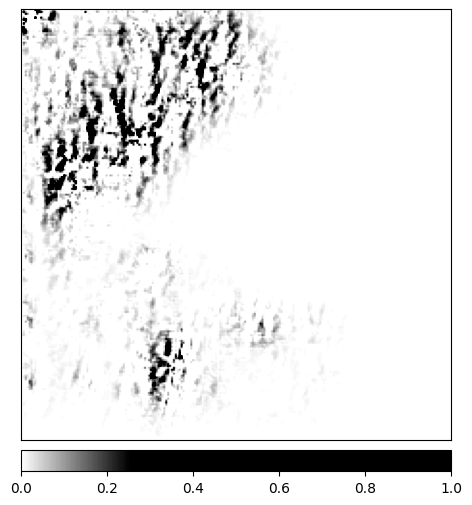

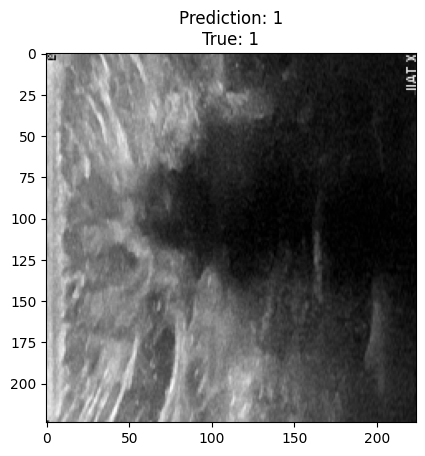

tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')


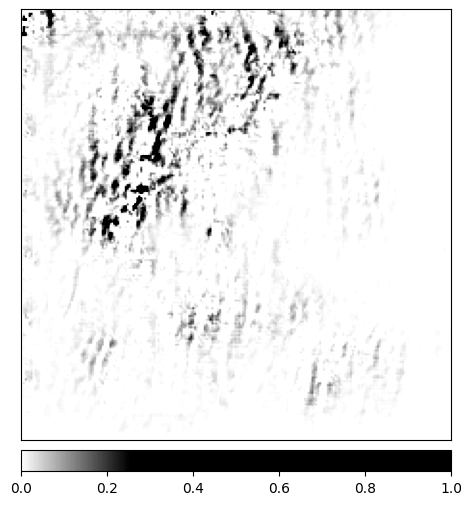

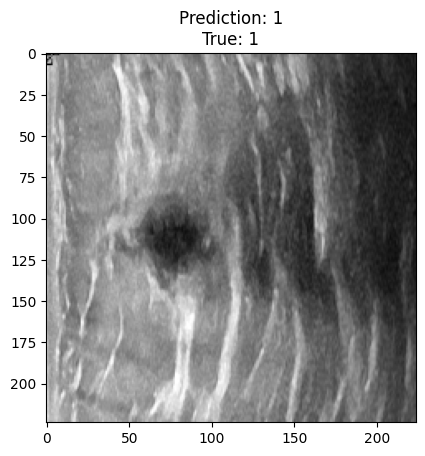

tensor([0, 0, 0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')


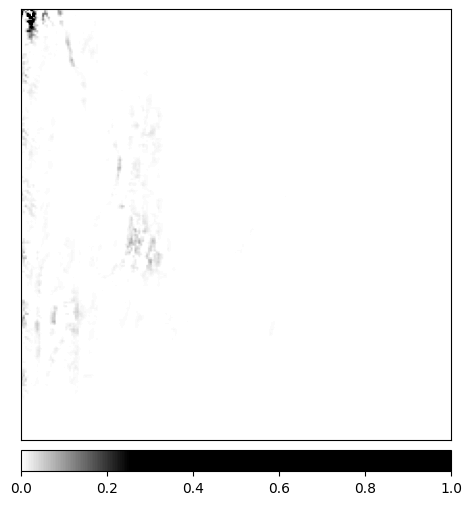

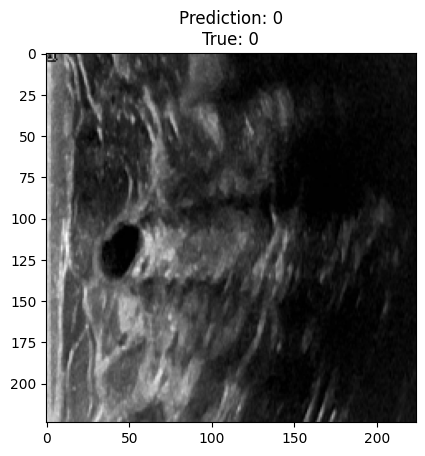

tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')


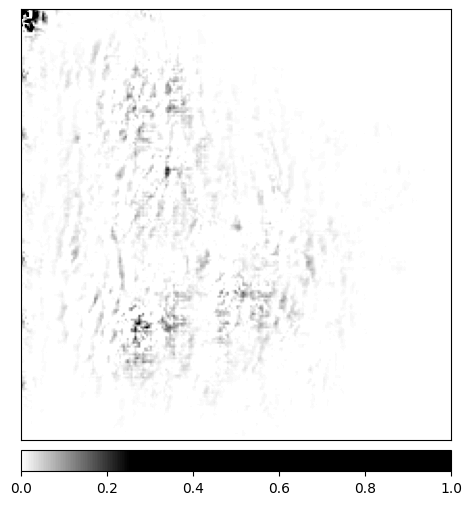

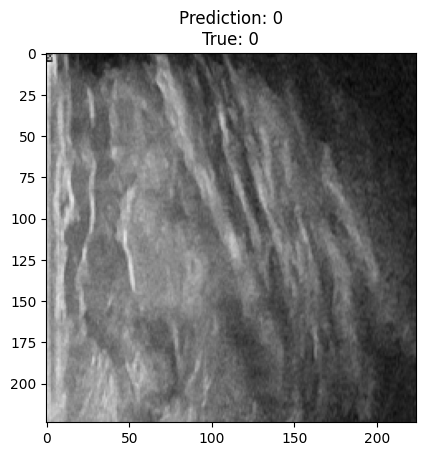

tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


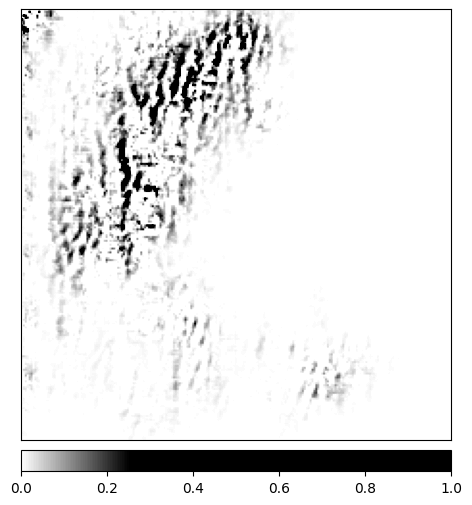

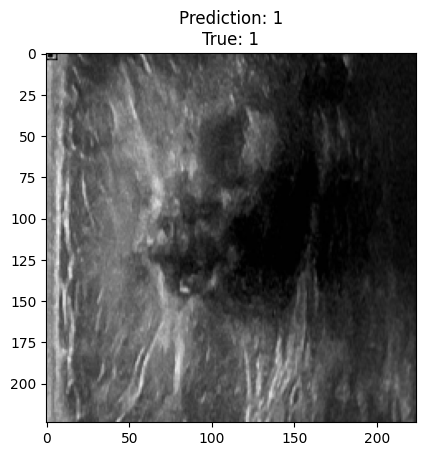

tensor([0, 0, 1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')


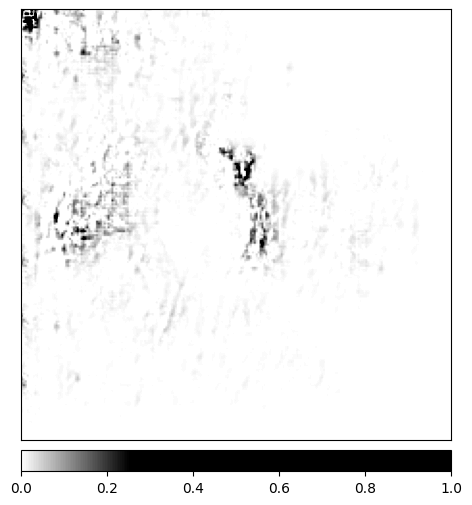

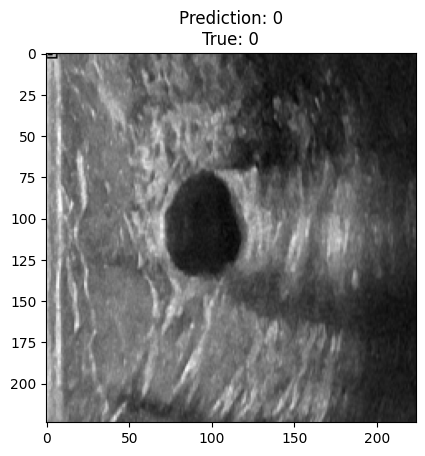

tensor([0, 0, 0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')


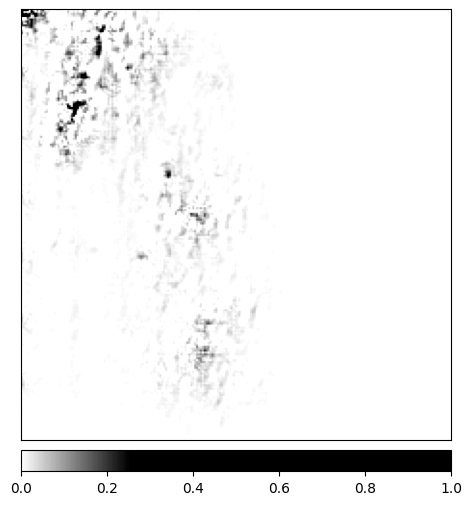

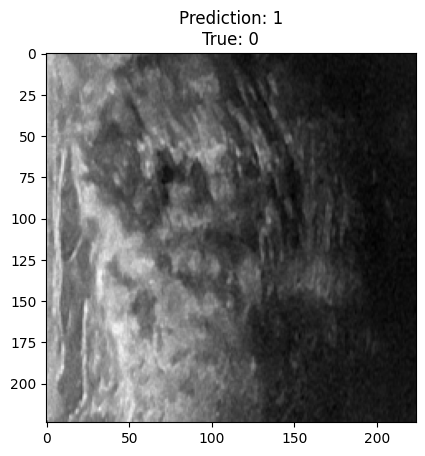

In [79]:
# adversarial model  
counter = 0 
for x, y in tqdm(train_loader):
    print(y)
    input = x[0].float() # 0th image in batch 
    attr = explain_classifier(adv_model, input.unsqueeze(0), y[:1])
    #print(attr.shape)
    visualize_classifier_exp(attr.squeeze().permute(2, 1, 0), 
                             x[0].squeeze().permute(2, 1, 0))
    plt.imshow(x[0].squeeze().permute(2, 1, 0))
    plt.title(f"Prediction: {adv_model.eval()(x[0].float().unsqueeze(0).to(device)).argmax()}\nTrue: {y[0].item()}")
    plt.show()

    if counter > 5:
      break
    counter +=1 


  0%|          | 0/80 [00:00<?, ?it/s]

tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')


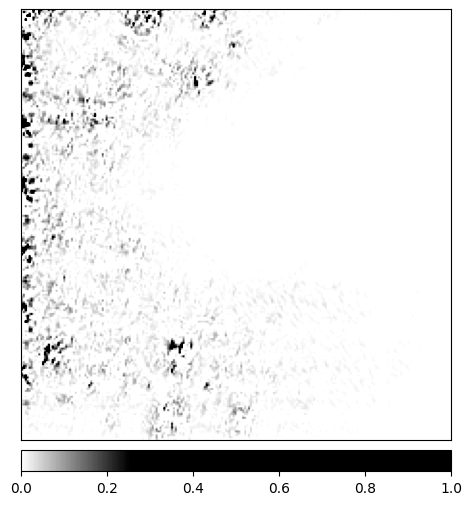

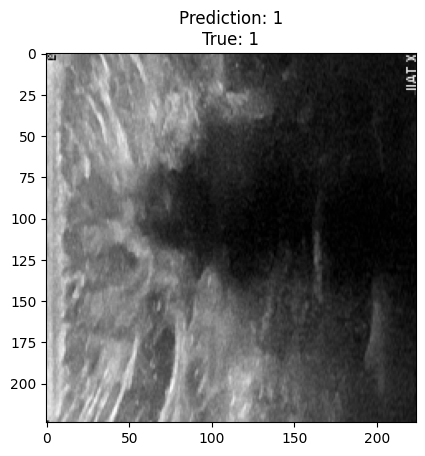

tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')


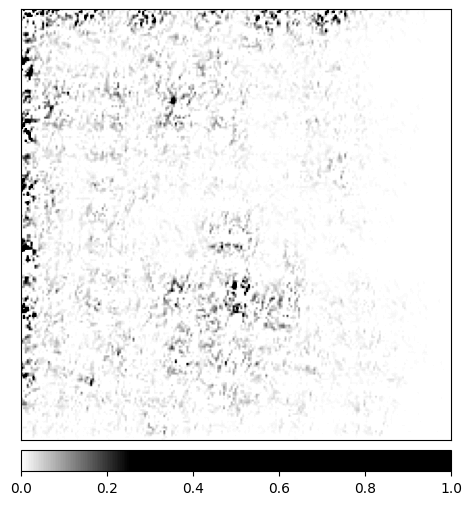

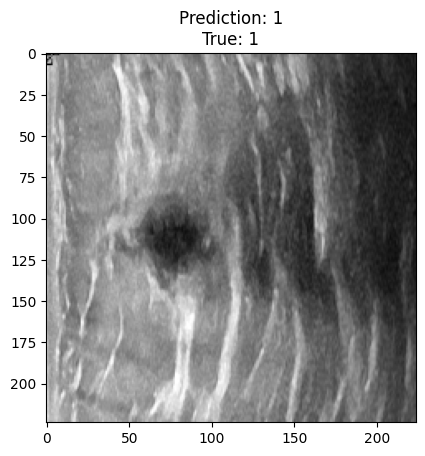

tensor([0, 0, 0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')


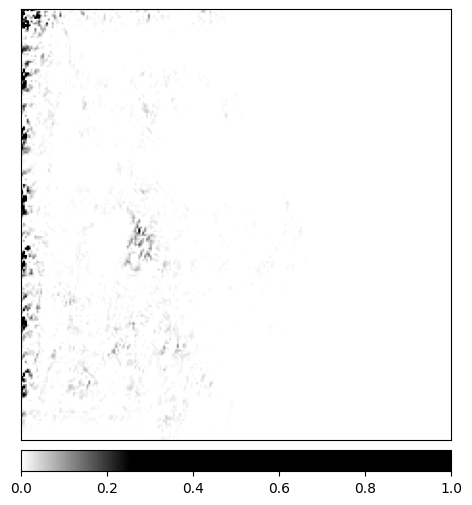

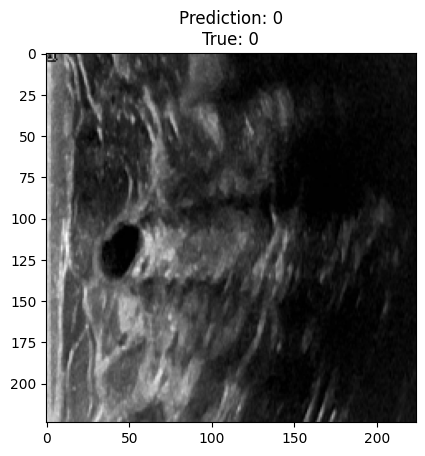

tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')


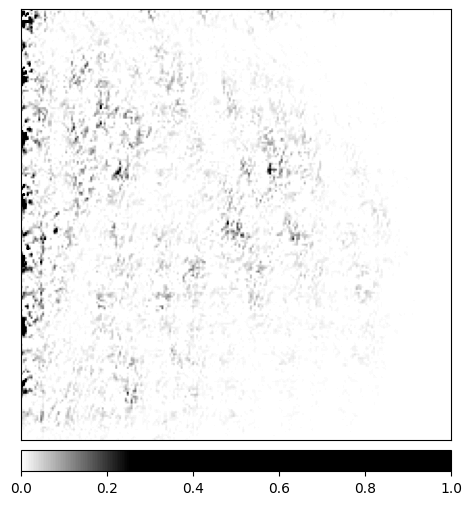

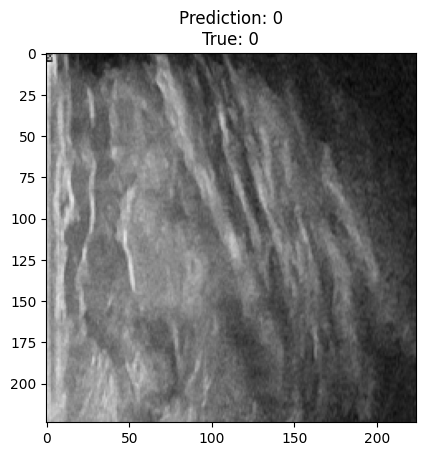

tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


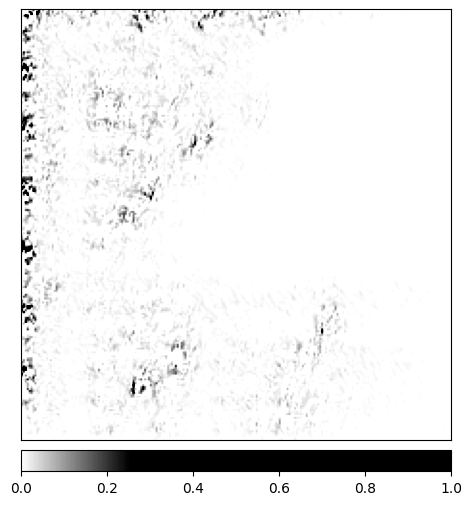

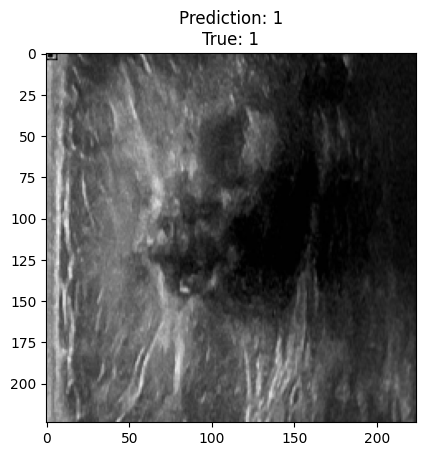

tensor([0, 0, 1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')


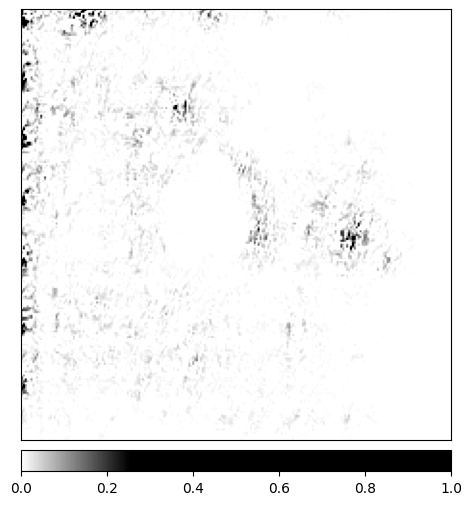

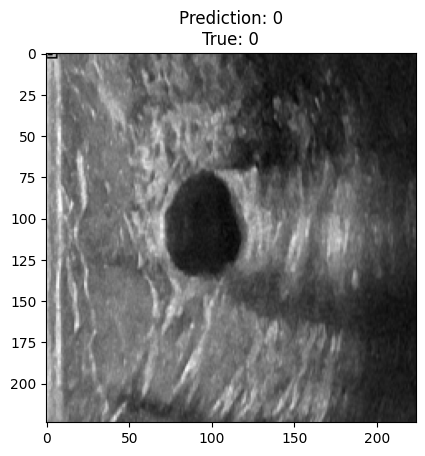

tensor([0, 0, 0, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')


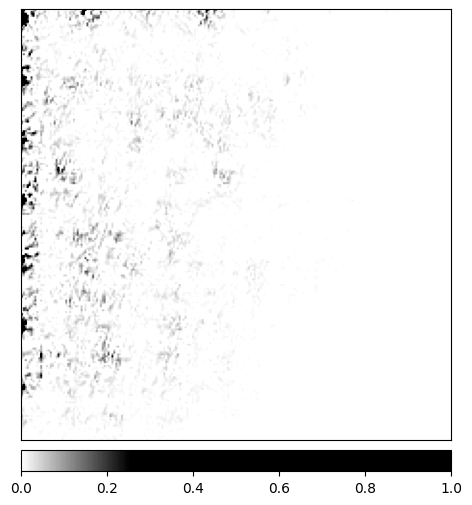

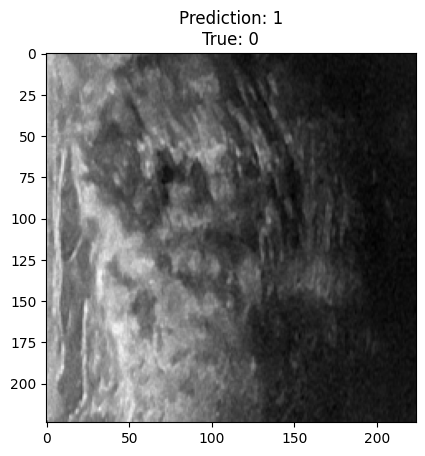

In [80]:
# baseline
counter = 0
for x, y in tqdm(train_loader):
    print(y)
    input = x[0].float() # 0th image in batch 
    attr = explain_classifier(baseline_model, input.unsqueeze(0), y[:1])
    #print(attr.shape)
    visualize_classifier_exp(attr.squeeze().permute(2, 1, 0), 
                             x[0].squeeze().permute(2, 1, 0))
    plt.imshow(x[0].squeeze().permute(2, 1, 0))
    plt.title(f"Prediction: {baseline_model.eval()(x[0].float().unsqueeze(0).to(device)).argmax()}\nTrue: {y[0].item()}")
    plt.show()

    if counter > 5:
      break
    counter +=1 

In [ ]:
from captum.robust import FGSM

  0%|          | 0/63 [00:00<?, ?it/s]

torch.Size([10, 3, 224, 224])


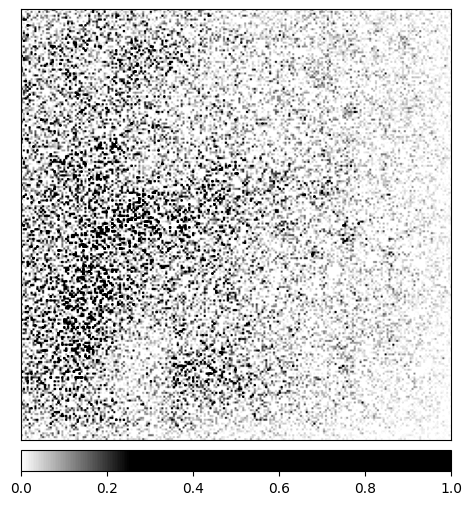

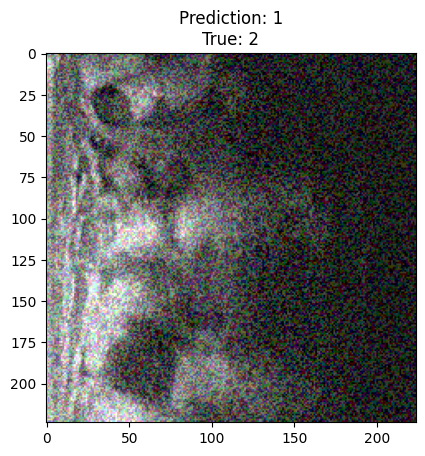

2


In [ ]:
# test fgsm attacker 
for x, y in tqdm(train_loader):
  image, label = x[0], y[0].item()
  attck = FGSM(baseline_model)
  x = x/255.0
  img = attck.perturb(x.float(), epsilon=0.15, target=label)
  #new_pred = baseline_model.eval()(img[0].float().unsqueeze(0).to(device)).argmax()
  print(img.shape)

  attr = explain_classifier(baseline_model, img[0].unsqueeze(0), y[:1])
  visualize_classifier_exp(attr.squeeze().permute(2, 1, 0), 
                             x[0].squeeze().permute(2, 1, 0))
  plt.imshow(img[0].squeeze().permute(2, 1, 0))
  plt.title(f"Prediction: {baseline_model.eval()(x[0].float().unsqueeze(0).to(device)).argmax()}\nTrue: {y[0].item()}")
  plt.show()


  #print(new_pred)
  print(label)
  break

  0%|          | 0/63 [00:00<?, ?it/s]

torch.Size([10, 3, 224, 224])


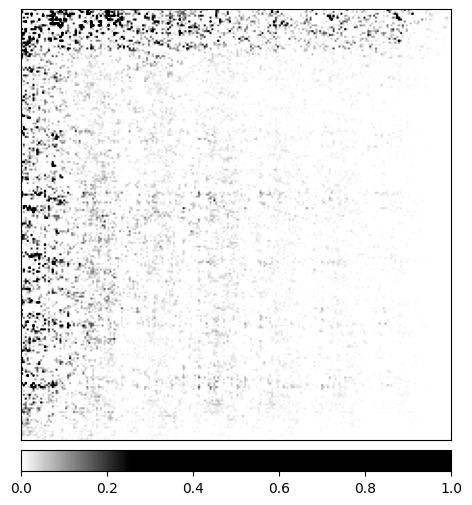

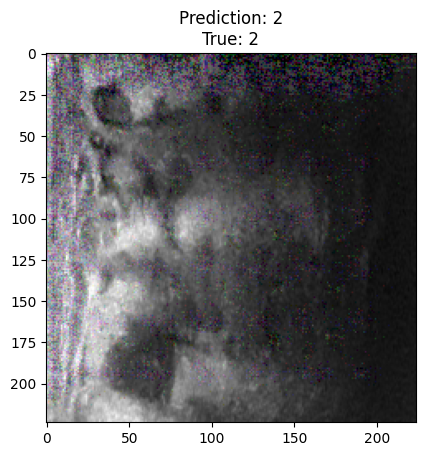

2


In [ ]:
# test fgsm attacker 
for x, y in tqdm(train_loader):
  image, label = x[0], y[0].item()
  attck = FGSM(adv_model)
  x = x/255.0
  img = attck.perturb(x.float(), epsilon=0.15, target=label)
  print(img.shape)

  attr = explain_classifier(adv_model, img[0].unsqueeze(0), y[:1])
  visualize_classifier_exp(attr.squeeze().permute(2, 1, 0), 
                             x[0].squeeze().permute(2, 1, 0))
  plt.imshow(img[0].squeeze().permute(2, 1, 0))
  plt.title(f"Prediction: {adv_model.eval()(x[0].float().unsqueeze(0).to(device)).argmax()}\nTrue: {y[0].item()}")
  plt.show()


  #print(new_pred)
  print(label)
  break